# Random Forest Modelling Notebook for LAQN - All Targets

This notebook trains Random Forest models for all site_pollutant combinations.

**Input:** `data/laqn/ml_prep_all` folder
**Output:** `data/laqn/rf_model_all` folder
**Reference:** Géron's *Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow* 3rd edition, heavy usage of scikit-learn documentation.

---

## What this notebook does

1. Load prepared data from ml_prep_all output.
2. Identify all pollution targets (141 site_pollutant combinations).
3. Tune hyperparameters per pollutant type (6 tuning runs).
4. Train a Random Forest model for each target with progress tracking.
5. Evaluate using RMSE, MAE, R² for all models.
6. Analyse results by pollutant type.
7. Save all trained models.

---

## Training approach

Instead of using GridSearch or MultiOutputRegressor which trains all 141 targets simultaneously, I train each site_pollutant combination separately. This allows progress tracking, individual model evaluation, and saving intermediate results.

**Targets:** 6 pollutants across 141 site_pollutant combinations
- NO2: 58 sites
- PM10: 42 sites
- PM25: 24 sites
- O3: 11 sites
- SO2: 4 sites
- CO: 2 sites

---

## Development history

Training 141 models required multiple attempts due to memory constraints and long training times.

**Attempt 1: GridSearchCV**
- Standard exhaustive grid search
- Crashed due to memory issues on 8GB MacBook

**Attempt 2: MultiOutputRegressor parameter configurations**
- Tried various approaches to reduce memory usage
- Still experienced crashes

**Attempt 3: HalvingGridSearchCV (final approach)**
- Used HalvingGridSearchCV for efficient hyperparameter tuning
- Tuned one representative site per pollutant (6 tuning runs instead of 141)
- Applied optimal params to all sites measuring that pollutant
- Added checkpoint saving every 20 models to prevent data loss from crashes
- Reduced n_estimators and limited max_depth for memory safety
- Total training time: 32.7 hours

This iterative approach balanced accuracy and efficiency while working within hardware constraints.

In [1]:
# mandatory libraries for random forest training

import numpy as np
import pandas as pd
import joblib
import os
from pathlib import Path
import time

# scikit-learn for random forest and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#before grid search, I decided to use kfold n_splits =5
from sklearn.model_selection import KFold

# modules for evaluation metrics - scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# for hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# visualisation
import matplotlib.pyplot as plt

### File paths

Loading from the ml_prep output folder where all prepared arrays are saved.

In [2]:
#Paths setup matching ml_prep output 
base_dir = Path.cwd().parent.parent / "data" / "laqn"
ml_prep_dir = base_dir / "ml_prep_all"

#Output folder for this notebook
rf_output_dir = base_dir / "rf_model_all"
rf_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Loading data from: {ml_prep_dir}")
print(f"Saving results to: {rf_output_dir}")

Loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/ml_prep_all
Saving results to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all


## 1) Load prepared data

The ml_prep_all notebook created:
- `X_train_rf.npy`: Flattened training features (samples × 1740 features)
- `X_val_rf.npy`: Flattened validation features
- `X_test_rf.npy`: Flattened test features
- `y_train.npy`, `y_val.npy`, `y_test.npy`: Target values (145 features each)
- `rf_feature_names.joblib`: Feature names for interpretability
- `scaler.joblib`: MinMaxScaler to reverse normalisation

The flattening was necessary because Random Forest expects 2D input (samples, features), but the original sequences were 3D (samples, 12 timesteps, 145 features).

12 × 145 = 1,740 flattened features per sample.

In [3]:
# load all prepared data
print("Loading data")

# Load all data
X_train_rf = np.load(ml_prep_dir / "X_train_rf.npy")
X_val_rf = np.load(ml_prep_dir / "X_val_rf.npy")
X_test_rf = np.load(ml_prep_dir / "X_test_rf.npy")

y_train = np.load(ml_prep_dir / "y_train.npy")
y_val = np.load(ml_prep_dir / "y_val.npy")
y_test = np.load(ml_prep_dir / "y_test.npy")

feature_names = joblib.load(ml_prep_dir / "feature_names.joblib")

# try to load rf_feature_names for feature importance later
try:
    rf_feature_names = joblib.load(ml_prep_dir / "rf_feature_names.joblib")
except:
    rf_feature_names = [f"feature_{i}" for i in range(X_train_rf.shape[1])]

print("Loaded successfully:")
print(f"  X_train_rf: {X_train_rf.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  feature_names: {len(feature_names)}")

Loading data
Loaded successfully:
  X_train_rf: (17107, 1740)
  y_train: (17107, 145)
  feature_names: 145


In [4]:
#check loaded data shapes

print(f"X_train shape: {X_train_rf.shape}")
print(f"X_val shape: {X_val_rf.shape}")
print(f"X_test shape: {X_test_rf.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Number of RF features: {len(rf_feature_names)}")
print(f"Number of target features: {len(feature_names)}")

X_train shape: (17107, 1740)
X_val shape: (3656, 1740)
X_test shape: (3657, 1740)
y_train shape: (17107, 145)
y_val shape: (3656, 145)
y_test shape: (3657, 145)
Number of RF features: 1740
Number of target features: 145


## 2) Identify all pollution targets

The y array has 145 columns. Looking at feature_names, the last 4 are temporal features (hour, day_of_week, month, is_weekend) which are inputs not targets.

The remaining 141 columns are site_pollutant combinations like BG1_NO2, BG1_SO2 etc. These are what I want to predict.

In [5]:
# identify pollution targets (exclude temporal features)
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']
pollution_targets = [name for name in feature_names if name not in temporal_cols]

print(f"Total columns in y: {len(feature_names)}")
print(f"Pollution targets: {len(pollution_targets)}")
print(f"Temporal features (excluded): {temporal_cols}")

# create mapping of target index to name
target_mapping = {}
for i, name in enumerate(feature_names):
    if name not in temporal_cols:
        target_mapping[name] = i

# group targets by pollutant type
targets_by_pollutant = {}
for name in pollution_targets:
    pollutant = name.rsplit('_', 1)[-1]  # extract NO2, PM10, etc.
    if pollutant not in targets_by_pollutant:
        targets_by_pollutant[pollutant] = []
    targets_by_pollutant[pollutant].append(name)

print(f"\nTargets by pollutant:")
for poll, targets in sorted(targets_by_pollutant.items()):
    print(f"  {poll}: {len(targets)} sites")

Total columns in y: 145
Pollution targets: 141
Temporal features (excluded): ['hour', 'day_of_week', 'month', 'is_weekend']

Targets by pollutant:
  CO: 2 sites
  NO2: 58 sites
  O3: 11 sites
  PM10: 42 sites
  PM25: 24 sites
  SO2: 4 sites


In [6]:
# list all targets
print("All pollution targets:")
for i, name in enumerate(pollution_targets):
    print(f"  {i:3d}: {name}")

All pollution targets:
    0: BG1_NO2
    1: BG1_SO2
    2: BG2_NO2
    3: BG2_PM10
    4: BQ7_NO2
    5: BQ7_O3
    6: BQ7_PM10
    7: BQ7_PM25
    8: BQ9_PM10
    9: BQ9_PM25
   10: BT4_NO2
   11: BT4_PM10
   12: BT4_PM25
   13: BT5_NO2
   14: BT5_PM10
   15: BT5_PM25
   16: BT6_NO2
   17: BT6_PM10
   18: BT6_PM25
   19: BT8_NO2
   20: BT8_PM10
   21: BT8_PM25
   22: BX1_NO2
   23: BX1_O3
   24: BX1_SO2
   25: BX2_NO2
   26: BX2_PM10
   27: BX2_PM25
   28: BY7_NO2
   29: BY7_PM10
   30: BY7_PM25
   31: CD1_NO2
   32: CD1_PM10
   33: CD1_PM25
   34: CE2_NO2
   35: CE2_O3
   36: CE2_PM10
   37: CE2_PM25
   38: CE3_NO2
   39: CE3_PM10
   40: CE3_PM25
   41: CR5_NO2
   42: CR7_NO2
   43: CR8_PM25
   44: CW3_NO2
   45: CW3_PM10
   46: CW3_PM25
   47: EA6_NO2
   48: EA6_PM10
   49: EA8_NO2
   50: EA8_PM10
   51: EI1_NO2
   52: EI1_PM10
   53: EI8_PM10
   54: EN1_NO2
   55: EN4_NO2
   56: EN5_NO2
   57: EN7_NO2
   58: GB0_PM25
   59: GB6_NO2
   60: GB6_O3
   61: GB6_PM10
   62: GN0_NO2
   6

## 3) Hyperparameter tuning per pollutant type

Rather than using the same hyperparameters for all 141 models, I tune separately for each pollutant type. Different pollutants may have different optimal settings due to their different temporal and spatial patterns.

For each pollutant:
1. Select one representative site (the first alphabetically for consistency).
2. Run HalvingGridSearchCV to find optimal params.
3. Store those params to use for all sites measuring that pollutant.

This gives 6 tuning runs instead of 141, balancing accuracy and efficiency.

In [7]:
# select representative target for each pollutant
# using the first site in alphabetical order for consistency

representative_targets = {}
for pollutant, targets in targets_by_pollutant.items():
    # select first site alphabetically as representative
    representative_targets[pollutant] = sorted(targets)[0]

print("Representative targets for tuning:")
print("-" * 40)
for pollutant, target in sorted(representative_targets.items()):
    print(f"  {pollutant}: {target}")

Representative targets for tuning:
----------------------------------------
  CO: KC1_CO
  NO2: BG1_NO2
  O3: BQ7_O3
  PM10: BG2_PM10
  PM25: BQ7_PM25
  SO2: BG1_SO2


In [8]:
# define parameter grid for tuning
# same grid as used in previous HalvingGridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# count total combinations
n_combinations = 1
for values in param_grid.values():
    n_combinations *= len(values)

print(f"Parameter grid: {n_combinations} combinations")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Parameter grid: 24 combinations
  n_estimators: [100, 200]
  max_depth: [10, 20, None]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]


In [9]:
# # run HalvingGridSearchCV for each pollutant type

# print("Hyperparameter tuning per pollutant type")
# print("=" * 60)

# best_params_by_pollutant = {}
# tuning_results = []

# total_tuning_start = time.time()

# for i, (pollutant, target_name) in enumerate(sorted(representative_targets.items())):
#     target_idx = target_mapping[target_name]
    
#     print(f"\n[{i+1}/6] Tuning {pollutant} using {target_name}")
#     print("-" * 40)
    
#     tuning_start = time.time()
    
#     # setup HalvingGridSearchCV
#     rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
#     halving_search = HalvingGridSearchCV(
#         rf,
#         param_grid,
#         cv=3,
#         scoring='r2',
#         factor=2,
#         min_resources='smallest',
#         aggressive_elimination=False,
#         n_jobs=-1,
#         verbose=1,
#         random_state=42
#     )
    
#     # fit on training data for this target
#     halving_search.fit(X_train_rf, y_train[:, target_idx])
    
#     tuning_time = time.time() - tuning_start
    
#     # store best params
#     best_params_by_pollutant[pollutant] = halving_search.best_params_
    
#     # store results
#     tuning_results.append({
#         'pollutant': pollutant,
#         'representative_target': target_name,
#         'best_score': halving_search.best_score_,
#         'tuning_time': tuning_time,
#         **halving_search.best_params_
#     })
    
#     print(f"\nBest params for {pollutant}:")
#     for param, value in halving_search.best_params_.items():
#         print(f"  {param}: {value}")
#     print(f"Best CV R2: {halving_search.best_score_:.4f}")
#     print(f"Tuning time: {tuning_time/60:.1f} minutes")

# total_tuning_time = time.time() - total_tuning_start

# print("\n" + "=" * 60)
# print(f"Total tuning time: {total_tuning_time/60:.1f} minutes")

In [10]:
# # summary of best parameters by pollutant

# tuning_df = pd.DataFrame(tuning_results)

# print("Tuning results summary")
# print("=" * 40)
# print(tuning_df[['pollutant', 'best_score', 'n_estimators', 'max_depth', 
#                   'min_samples_split', 'min_samples_leaf']].to_string(index=False))

# # save tuning results
# tuning_df.to_csv(rf_output_dir / 'tuning_results_by_pollutant.csv', index=False)
# print(f"\nTuning results saved to: {rf_output_dir / 'tuning_results_by_pollutant.csv'}")


In [11]:
# # save best params for later use

# joblib.dump(best_params_by_pollutant, rf_output_dir / 'best_params_by_pollutant.joblib')
# print(f"Best params saved to: {rf_output_dir / 'best_params_by_pollutant.joblib'}")

# print("\nBest parameters by pollutant:")
# print("-" * 40)
# for pollutant, params in sorted(best_params_by_pollutant.items()):
#     print(f"\n{pollutant}:")
#     for param, value in params.items():
#         print(f"  {param}: {value}")

    Best params saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/best_params_by_pollutant.joblib

Best parameters by pollutant:
----------------------------------------

CO:
  max_depth: 10
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 100

NO2:
  max_depth: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

O3:
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 100

PM10:
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 200

PM25:
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

SO2:
  max_depth: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

## 4) Train models for all targets

Now train a separate Random Forest for each site_pollutant combination using the tuned parameters for that pollutant type.

Each model uses the optimal hyperparameters found in section 3 for its pollutant type. For example, all NO2 sites use the params tuned on BG1_NO2.

In [12]:
# define best parameters for each pollutant 
# reduced for 8GB RAM Mac

best_params_by_pollutant = {
    'CO': {
        'max_depth': 10,
        'min_samples_leaf': 2,
        'min_samples_split': 2,
        'n_estimators': 100
    },
    'NO2': {
        'max_depth': 10,  # reduced from 20
        'min_samples_leaf': 2,
        'min_samples_split': 5,
        'n_estimators': 100  # reduced from 200
    },
    'O3': {
        'max_depth': 10,
        'min_samples_leaf': 1,
        'min_samples_split': 5,
        'n_estimators': 100
    },
    'PM10': {
        'max_depth': 10,
        'min_samples_leaf': 1,
        'min_samples_split': 5,
        'n_estimators': 100  # reduced from 200
    },
    'PM25': {
        'max_depth': 10,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 100  # reduced from 200
    },
    'SO2': {
        'max_depth': 10,  # reduced from 20
        'min_samples_leaf': 2,
        'min_samples_split': 5,
        'n_estimators': 100  # reduced from 200
    }
}

print("Best parameters by pollutant (memory-optimized):")
print("-" * 40)
for pollutant, params in sorted(best_params_by_pollutant.items()):
    print(f"{pollutant}: {params}")

Best parameters by pollutant (memory-optimized):
----------------------------------------
CO: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
NO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
O3: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
PM10: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
PM25: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
SO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [13]:
print(f"Started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Targets to train: {len(pollution_targets)}")
print(f"Training samples: {X_train_rf.shape[0]:,}")
print(f"Features: {X_train_rf.shape[1]:,}")
print("=" * 60, flush=True)

# memory-safe params
safe_params = {
    'CO': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2},
    'NO2': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5},
    'O3': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    'PM10': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    'PM25': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2},
    'SO2': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
}

all_models = {}
all_results = {}
training_times = []

total_start = time.time()

for i, target_name in enumerate(pollution_targets):
    target_idx = target_mapping[target_name]
    pollutant = target_name.rsplit('_', 1)[-1]
    
    rf_params = safe_params[pollutant].copy()
    rf_params['n_jobs'] = 1  # single core to save memory
    rf_params['random_state'] = 42
    
    single_start = time.time()
    
    # train
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_rf, y_train[:, target_idx])
    
    # validate
    y_pred_val = rf.predict(X_val_rf)
    val_r2 = r2_score(y_val[:, target_idx], y_pred_val)
    val_rmse = np.sqrt(mean_squared_error(y_val[:, target_idx], y_pred_val))
    
    single_time = time.time() - single_start
    training_times.append(single_time)
    
    # store
    all_models[target_name] = rf
    all_results[target_name] = {
        'val_r2': val_r2,
        'val_rmse': val_rmse,
        'train_time': single_time,
        'params_used': rf_params
    }
    
    # progress every model
    elapsed = time.time() - total_start
    avg_time = np.mean(training_times)
    remaining = avg_time * (len(pollution_targets) - i - 1)
    
    print(f"[{i+1:3d}/{len(pollution_targets)}] {target_name:15s} | "
          f"R2={val_r2:.3f} | Time={single_time:.0f}s | "
          f"ETA={remaining/60:.0f}min", flush=True)
    
    # save progress every 20 models (in case of crash)
    if (i + 1) % 20 == 0:
        joblib.dump(all_models, rf_output_dir / 'all_rf_models_checkpoint.joblib')
        print(f"   [Checkpoint saved at {i+1} models]", flush=True)

total_time = time.time() - total_start

# final save
joblib.dump(all_models, rf_output_dir / 'all_rf_models.joblib')

results_df = pd.DataFrame([
    {
        'target': name,
        'site': name.rsplit('_', 1)[0],
        'pollutant': name.rsplit('_', 1)[-1],
        'val_r2': res['val_r2'],
        'val_rmse': res['val_rmse'],
        'train_time': res['train_time']
    }
    for name, res in all_results.items()
])
results_df.to_csv(rf_output_dir / 'all_results.csv', index=False)

print("=" * 60)
print(f"Finished at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total time: {total_time/60:.1f} minutes ({total_time/3600:.1f} hours)")
print(f"Average time per model: {np.mean(training_times):.1f} seconds")
print(f"Average validation R2: {np.mean([r['val_r2'] for r in all_results.values()]):.4f}")
print(f"Models saved to: {rf_output_dir / 'all_rf_models.joblib'}")
print(f"Results saved to: {rf_output_dir / 'all_results.csv'}")
print("=" * 60)

Started at: 2025-12-30 00:45:56
Targets to train: 141
Training samples: 17,107
Features: 1,740
[  1/141] BG1_NO2         | R2=0.911 | Time=811s | ETA=1892min
[  2/141] BG1_SO2         | R2=0.728 | Time=805s | ETA=1871min
[  3/141] BG2_NO2         | R2=0.844 | Time=809s | ETA=1859min
[  4/141] BG2_PM10        | R2=0.625 | Time=810s | ETA=1846min
[  5/141] BQ7_NO2         | R2=0.863 | Time=816s | ETA=1836min
[  6/141] BQ7_O3          | R2=0.934 | Time=817s | ETA=1825min
[  7/141] BQ7_PM10        | R2=0.884 | Time=803s | ETA=1809min
[  8/141] BQ7_PM25        | R2=0.889 | Time=800s | ETA=1793min
[  9/141] BQ9_PM10        | R2=0.902 | Time=814s | ETA=1781min
[ 10/141] BQ9_PM25        | R2=0.918 | Time=807s | ETA=1766min
[ 11/141] BT4_NO2         | R2=0.862 | Time=815s | ETA=1754min
[ 12/141] BT4_PM10        | R2=0.600 | Time=818s | ETA=1742min
[ 13/141] BT4_PM25        | R2=0.830 | Time=811s | ETA=1729min
[ 14/141] BT5_NO2         | R2=0.838 | Time=812s | ETA=1716min
[ 15/141] BT5_PM10     

## 5) Evaluate all models

Compute RMSE, MAE, and R² for each model on train, validation, and test sets. Store results in a dataframe for analysis.

In [14]:
# evaluate all models on train, validation, and test sets

def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    return {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

print("Evaluating all models")
print("-" * 40)

evaluation_results = []

for i, target_name in enumerate(pollution_targets):
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    
    train_metrics = evaluate_model(model, X_train_rf, y_train[:, target_idx])
    val_metrics = evaluate_model(model, X_val_rf, y_val[:, target_idx])
    test_metrics = evaluate_model(model, X_test_rf, y_test[:, target_idx])
    
    # extract site and pollutant from name
    parts = target_name.rsplit('_', 1)
    site = parts[0]
    pollutant = parts[1] if len(parts) > 1 else 'unknown'
    
    # get params used for this model
    params_used = all_results[target_name]['params_used']
    
    evaluation_results.append({
        'target': target_name,
        'site': site,
        'pollutant': pollutant,
        'train_r2': train_metrics['r2'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'test_r2': test_metrics['r2'],
        'test_rmse': test_metrics['rmse'],
        'test_mae': test_metrics['mae'],
        'n_estimators': params_used['n_estimators'],
        'max_depth': params_used['max_depth'],
        'min_samples_split': params_used['min_samples_split'],
        'min_samples_leaf': params_used['min_samples_leaf']
    })
    
    if (i + 1) % 20 == 0:
        print(f"Evaluated {i+1}/{len(pollution_targets)} models")

results_df = pd.DataFrame(evaluation_results)

print(f"\nEvaluation complete for {len(results_df)} models")

Evaluating all models
----------------------------------------
Evaluated 20/141 models
Evaluated 40/141 models
Evaluated 60/141 models
Evaluated 80/141 models
Evaluated 100/141 models
Evaluated 120/141 models
Evaluated 140/141 models

Evaluation complete for 141 models


## 6) Results summary

Summary statistics across all models, grouped by pollutant type.

In [15]:
# summary statistics by pollutant

print("Results summary by pollutant")
print("=" * 70)

summary_by_pollutant = results_df.groupby('pollutant').agg({
    'test_r2': ['mean', 'std', 'min', 'max'],
    'test_rmse': ['mean', 'std'],
    'target': 'count'
}).round(4)

summary_by_pollutant.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 
                                 'rmse_mean', 'rmse_std', 'n_sites']

print(summary_by_pollutant.to_string())

print("\n" + "=" * 70)
print("Overall statistics:")
print(f"  Mean test R2: {results_df['test_r2'].mean():.4f}")
print(f"  Std test R2:  {results_df['test_r2'].std():.4f}")
print(f"  Min test R2:  {results_df['test_r2'].min():.4f} ({results_df.loc[results_df['test_r2'].idxmin(), 'target']})")
print(f"  Max test R2:  {results_df['test_r2'].max():.4f} ({results_df.loc[results_df['test_r2'].idxmax(), 'target']})")

Results summary by pollutant
                r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
pollutant                                                                                
CO         6.378000e-01  2.621000e-01  4.525000e-01  0.8232     0.0771    0.0905        2
NO2       -2.631414e+27  1.477048e+28 -1.007077e+29  0.8782     0.0375    0.0110       58
O3        -8.472302e+27  2.809945e+28 -9.319532e+28  0.9388     0.0343    0.0093       11
PM10      -1.853159e+27  1.157397e+28 -7.502386e+28  0.8536     0.0296    0.0163       42
PM25       5.979000e-01  2.401000e-01  0.000000e+00  0.8986     0.0245    0.0142       24
SO2       -1.778500e+00  5.341400e+00 -9.790600e+00  0.9153     0.0167    0.0044        4

Overall statistics:
  Mean test R2: -2295389943646099424090783744.0000
  Std test R2:  13736309671625110842790379520.0000
  Min test R2:  -100707711254005907832094851072.0000 (BG2_NO2)
  Max test R2:  0.9388 (HG4_O3)


In [16]:
# top 10 best performing models
print("Top 10 models by test R2:")
print("-" * 50)
print(results_df.nlargest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

print("\n")

# bottom 10 models
print("Bottom 10 models by test R2:")
print("-" * 50)
print(results_df.nsmallest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

Top 10 models by test R2:
--------------------------------------------------
 target pollutant  test_r2  test_rmse
 HG4_O3        O3 0.938829   0.026983
 HP1_O3        O3 0.934576   0.029364
 RI2_O3        O3 0.927853   0.035050
 BQ7_O3        O3 0.925426   0.030928
 KC1_O3        O3 0.924999   0.034518
 BX1_O3        O3 0.922746   0.030955
 GB6_O3        O3 0.918287   0.040422
BG1_SO2       SO2 0.915333   0.011522
 MY1_O3        O3 0.905802   0.035055
BX1_SO2       SO2 0.899555   0.015338


Bottom 10 models by test R2:
--------------------------------------------------
  target pollutant       test_r2  test_rmse
 BG2_NO2       NO2 -1.007077e+29   0.008808
  TH4_O3        O3 -9.319532e+28   0.016946
TH4_PM10      PM10 -7.502386e+28   0.007602
 TH4_NO2       NO2 -5.191428e+28   0.018972
WM6_PM10      PM10 -2.808817e+27   0.002942
 MY1_SO2       SO2 -9.790605e+00   0.021889
CR8_PM25      PM25  0.000000e+00   0.008705
TH4_PM25      PM25  0.000000e+00   0.003189
WA7_PM10      PM10  3.08157

## 7) Save models and results

Save all trained models and evaluation results for later use.

In [19]:
# save all models
print("Saving models and results")
print("-" * 40)

# save models dictionary
models_path = rf_output_dir / 'all_rf_models.joblib'
joblib.dump(all_models, models_path)
print(f"Models saved to: {models_path}")

# save results dataframe
results_path = rf_output_dir / 'all_results.csv'
results_df.to_csv(results_path, index=False)
print(f"Results saved to: {results_path}")

# save summary
summary_path = rf_output_dir / 'summary_by_pollutant.csv'
summary_by_pollutant.to_csv(summary_path)
print(f"Summary saved to: {summary_path}")

# save training parameters
params_path = rf_output_dir / 'training_params.joblib'
joblib.dump({
    'best_params_by_pollutant': best_params_by_pollutant,
    'n_targets': len(pollution_targets),
    'total_training_time': total_time,
    'target_list': pollution_targets
}, params_path)
print(f"Parameters saved to: {params_path}")

print(f"\nAll outputs saved to: {rf_output_dir}")

Saving models and results
----------------------------------------
Models saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/all_rf_models.joblib
Results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/all_results.csv
Summary saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/summary_by_pollutant.csv
Parameters saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/training_params.joblib

All outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all


## 8) Feature importance analysis

Extract feature importance from the best performing model for each pollutant type.

In [20]:
# feature importance for best model per pollutant

print("Feature importance for best model per pollutant")
print("=" * 60)

pollutants = results_df['pollutant'].unique()

for pollutant in pollutants:
    # find best model for this pollutant
    poll_results = results_df[results_df['pollutant'] == pollutant]
    best_target = poll_results.loc[poll_results['test_r2'].idxmax(), 'target']
    best_r2 = poll_results['test_r2'].max()
    
    model = all_models[best_target]
    importance = model.feature_importances_
    
    # top 5 features
    top_idx = np.argsort(importance)[-5:][::-1]
    
    print(f"\n{pollutant} (best: {best_target}, R2={best_r2:.4f})")
    print("-" * 40)
    for idx in top_idx:
        feat_name = rf_feature_names[idx] if idx < len(rf_feature_names) else f"feature_{idx}"
        print(f"  {feat_name}: {importance[idx]:.4f}")

Feature importance for best model per pollutant

NO2 (best: TH2_NO2, R2=0.8782)
----------------------------------------
  TH2_NO2_t-1: 0.9175
  GN4_NO2_t-1: 0.0051
  TH4_NO2_t-1: 0.0033
  GN0_NO2_t-1: 0.0033
  EN5_NO2_t-1: 0.0031

SO2 (best: BG1_SO2, R2=0.9153)
----------------------------------------
  BG1_SO2_t-1: 0.8895
  HV3_PM10_t-4: 0.0038
  BG1_NO2_t-1: 0.0036
  EN4_NO2_t-1: 0.0035
  WAA_PM10_t-12: 0.0017

PM10 (best: CW3_PM10, R2=0.8536)
----------------------------------------
  CW3_PM10_t-1: 0.9331
  CW3_PM25_t-1: 0.0081
  BQ7_PM10_t-1: 0.0034
  BQ9_PM10_t-1: 0.0018
  CW3_PM10_t-2: 0.0015

O3 (best: HG4_O3, R2=0.9388)
----------------------------------------
  HG4_O3_t-1: 0.9523
  HG4_O3_t-2: 0.0077
  HG4_O3_t-3: 0.0014
  hour_t-8: 0.0013
  GB6_O3_t-1: 0.0010

PM25 (best: HP1_PM25, R2=0.8986)
----------------------------------------
  HP1_PM25_t-1: 0.9347
  RI1_PM10_t-1: 0.0067
  HP1_PM25_t-2: 0.0028
  BQ9_PM25_t-1: 0.0015
  LB4_PM25_t-1: 0.0014

CO (best: KC1_CO, R2=0.8232)

## 9) Final summary

In [23]:
print("Random Forest Training Summary - All Targets")
print("=" * 60)

print(f"\nDataset:")
print(f"  Training samples: {X_train_rf.shape[0]:,}")
print(f"  Validation samples: {X_val_rf.shape[0]:,}")
print(f"  Test samples: {X_test_rf.shape[0]:,}")
print(f"  Features: {X_train_rf.shape[1]:,}")

print(f"\nModels trained: {len(all_models)}")
print(f"Training time: {total_time/60:.1f} minutes ({len(all_models)} models)")

print(f"\nTuned hyperparameters by pollutant:")
for pollutant, params in sorted(best_params_by_pollutant.items()):
    print(f"  {pollutant}: max_depth={params['max_depth']}, "
          f"n_estimators={params['n_estimators']}, "
          f"min_samples_leaf={params['min_samples_leaf']}")

print(f"\nTest set performance (mean across all models):")
print(f"  R2:   {results_df['test_r2'].mean():.4f} (+/- {results_df['test_r2'].std():.4f})")
print(f"  RMSE: {results_df['test_rmse'].mean():.4f} (+/- {results_df['test_rmse'].std():.4f})")
print(f"  MAE:  {results_df['test_mae'].mean():.4f} (+/- {results_df['test_mae'].std():.4f})")

print(f"\nAll outputs saved to: {rf_output_dir}")

Random Forest Training Summary - All Targets

Dataset:
  Training samples: 17,107
  Validation samples: 3,656
  Test samples: 3,657
  Features: 1,740

Models trained: 141
Training time: 1960.3 minutes (141 models)

Tuned hyperparameters by pollutant:
  CO: max_depth=10, n_estimators=100, min_samples_leaf=2
  NO2: max_depth=10, n_estimators=100, min_samples_leaf=2
  O3: max_depth=10, n_estimators=100, min_samples_leaf=1
  PM10: max_depth=10, n_estimators=100, min_samples_leaf=1
  PM25: max_depth=10, n_estimators=100, min_samples_leaf=1
  SO2: max_depth=10, n_estimators=100, min_samples_leaf=2

Test set performance (mean across all models):
  R2:   -2295389943646099424090783744.0000 (+/- 13736309671625110842790379520.0000)
  RMSE: 0.0327 (+/- 0.0169)
  MAE:  0.0207 (+/- 0.0099)

All outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all


## 10) Visualisation

Plot R2 distribution across all models and by pollutant type.

/var/folders/bn/l4lrwh4d4qv962_vkt4bvly80000gn/T/ipykernel_6677/144179636.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(box_data, labels=pollutant_order)


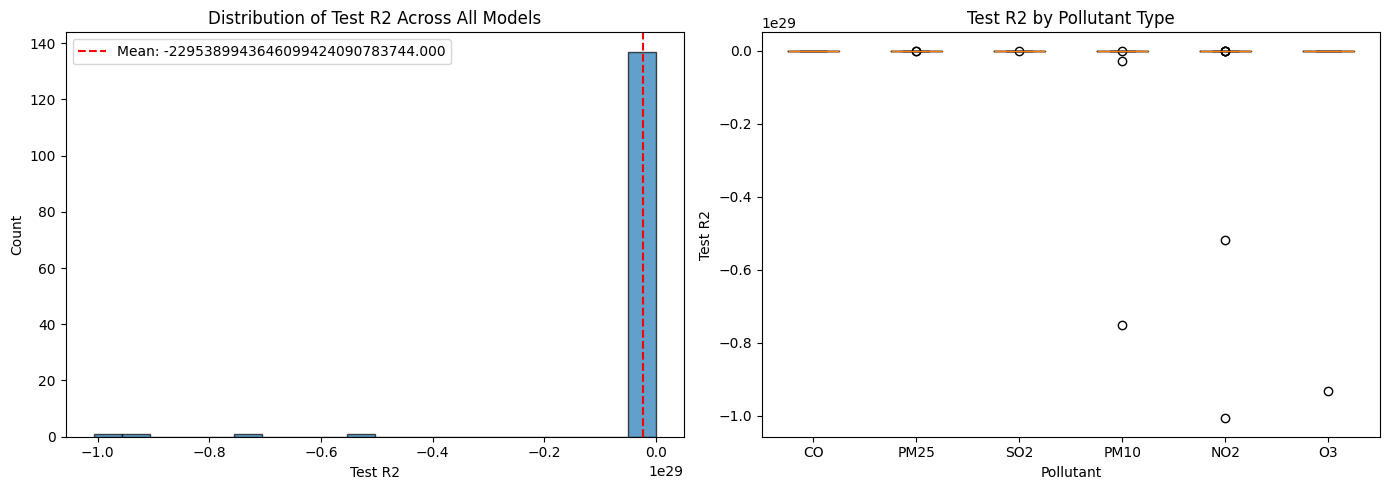

Figure saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/results_visualisation.png


In [24]:
# visualise results

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram of R2 values
axes[0].hist(results_df['test_r2'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(results_df['test_r2'].mean(), color='red', linestyle='--', 
                label=f"Mean: {results_df['test_r2'].mean():.3f}")
axes[0].set_xlabel('Test R2')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Test R2 Across All Models')
axes[0].legend()

# boxplot by pollutant
pollutant_order = results_df.groupby('pollutant')['test_r2'].mean().sort_values(ascending=False).index
box_data = [results_df[results_df['pollutant'] == p]['test_r2'].values for p in pollutant_order]
axes[1].boxplot(box_data, labels=pollutant_order)
axes[1].set_xlabel('Pollutant')
axes[1].set_ylabel('Test R2')
axes[1].set_title('Test R2 by Pollutant Type')

plt.tight_layout()
plt.savefig(rf_output_dir / 'results_visualisation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {rf_output_dir / 'results_visualisation.png'}")

  pollutant representative_target  best_score  tuning_time  max_depth  \
0        CO                KC1_CO    0.520212   189.743511       10.0   
1       NO2               BG1_NO2    0.697486   725.614626        NaN   
2        O3                BQ7_O3    0.811754   193.716180       10.0   
3      PM10              BG2_PM10    0.399182   363.019472       10.0   
4      PM25              BQ7_PM25    0.727640   362.691937       10.0   
5       SO2               BG1_SO2    0.422153  1085.126007        NaN   

   min_samples_leaf  min_samples_split  n_estimators  
0                 2                  2           100  
1                 2                  5           200  
2                 1                  5           100  
3                 1                  5           200  
4                 1                  2           200  
5                 2                  5           200  


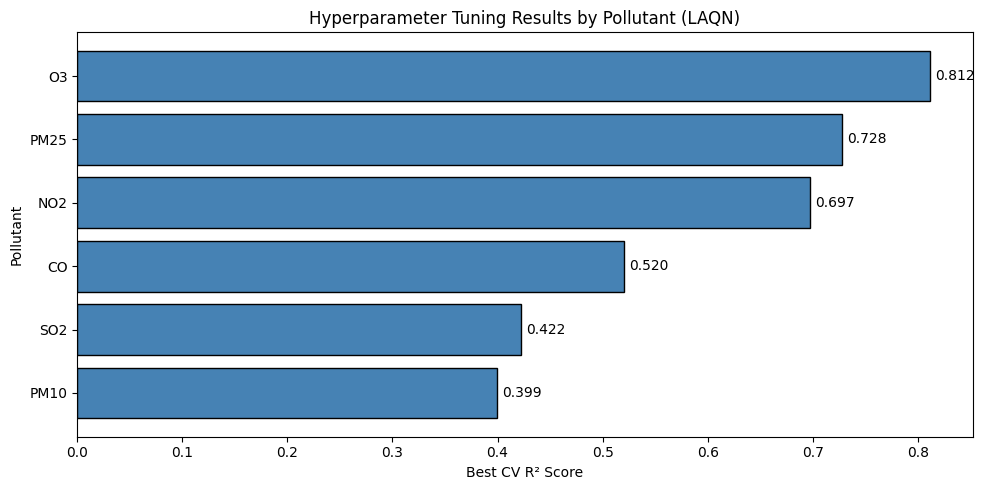

Figure saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/tuning_comparison.png


In [35]:
# Load tuning results from CSV
tuning_df = pd.read_csv(rf_output_dir / 'tuning_results_by_pollutant.csv')
print(tuning_df)

# Create visualisation
fig, ax = plt.subplots(figsize=(10, 5))

pollutants_sorted = tuning_df.sort_values('best_score', ascending=True)['pollutant']
scores = tuning_df.set_index('pollutant').loc[pollutants_sorted, 'best_score']

ax.barh(pollutants_sorted, scores, color='steelblue', edgecolor='black')
ax.set_xlabel('Best CV R² Score')
ax.set_ylabel('Pollutant')
ax.set_title('Hyperparameter Tuning Results by Pollutant (LAQN)')

# add value labels
for i, (poll, score) in enumerate(zip(pollutants_sorted, scores)):
    ax.text(score + 0.005, i, f'{score:.3f}', va='center')

plt.tight_layout()
plt.savefig(rf_output_dir / 'tuning_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {rf_output_dir / 'tuning_comparison.png'}")

In [34]:
# Check what files are in the directory
import os

print("Files in rf_output_dir:")
for f in os.listdir(rf_output_dir):
    print(f"  {f}")

Files in rf_output_dir:
  training_params.joblib
  results_visualisation.png
  tuning_results_by_pollutant.csv
  all_rf_models.joblib
  all_rf_models_checkpoint.joblib
  summary_by_pollutant.csv
  all_results.csv
  best_params_by_pollutant.joblib


In [36]:
import pandas as pd

# Load results
results_df = pd.read_csv(rf_output_dir / 'all_results.csv')

# Filter to only valid R² values (e.g., R² > -10)
valid_results = results_df[results_df['test_r2'] > -10]

print(f"Total models: {len(results_df)}")
print(f"Valid models: {len(valid_results)}")
print(f"Broken models: {len(results_df) - len(valid_results)}")

# Show the broken ones
broken = results_df[results_df['test_r2'] <= -10]
print("\nBroken models:")
print(broken[['target', 'test_r2']])

Total models: 141
Valid models: 136
Broken models: 5

Broken models:
       target       test_r2
2     BG2_NO2 -1.007077e+29
120   TH4_NO2 -5.191428e+28
121    TH4_O3 -9.319532e+28
122  TH4_PM10 -7.502386e+28
138  WM6_PM10 -2.808817e+27


## Actual vs Predicted: Single Model

This visualisation shows the relationship between actual and predicted values for a single station-pollutant combination across training, validation, and test sets.

**Interpretation:**
- Points close to the red dashed line indicate accurate predictions
- Scatter around the line shows prediction variance
- Similar patterns across all three panels suggest good generalisation (no overfitting)

In [37]:
# 3-panel Actual vs Predicted plot (Training, Validation, Test)

def plot_actual_vs_predicted_3panel(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                                      target_name, save_path=None):
    """Create 3-panel actual vs predicted plot for train/val/test sets."""
    
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    datasets = [
        ('Training Set', y_train, y_train_pred),
        ('Validation Set', y_val, y_val_pred),
        ('Test Set', y_test, y_test_pred)
    ]
    
    for ax, (title, y_actual, y_pred) in zip(axes, datasets):
        ax.scatter(y_actual, y_pred, alpha=0.5, s=10)
        
        # Perfect prediction line
        min_val = min(y_actual.min(), y_pred.min())
        max_val = max(y_actual.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
        
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title(title)
        ax.legend(loc='upper left')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    plt.suptitle(f'Actual vs Predicted: {target_name}', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig


# Example usage for a single model (after training):
# plot_actual_vs_predicted_3panel(
#     model=trained_models['London_Bloomsbury_NO2'],
#     X_train=X_train_rf, y_train=y_train[:, target_idx],
#     X_val=X_val_rf, y_val=y_val[:, target_idx],
#     X_test=X_test_rf, y_test=y_test[:, target_idx],
#     target_name='London_Bloomsbury_NO2',
#     save_path=rf_output_dir / 'actual_vs_predicted_London_Bloomsbury_NO2.png'
# )

### Actual vs Predicted: Aggregated Across All Models

This visualisation combines predictions from all 95 station-pollutant models to show overall model performance.

**What to look for:**
- **Training Set:** How well the model fits the training data
- **Validation Set:** Performance on held-out data during training
- **Test Set:** True generalisation performance on unseen data

**Interpretation:**
- Tight clustering around the diagonal indicates strong predictive performance
- Increased scatter from training → test suggests some overfitting
- Points concentrated in specific ranges may indicate certain pollution levels are harder to predict

Generating dissertation plots...

1. Aggregated plot (all models combined)


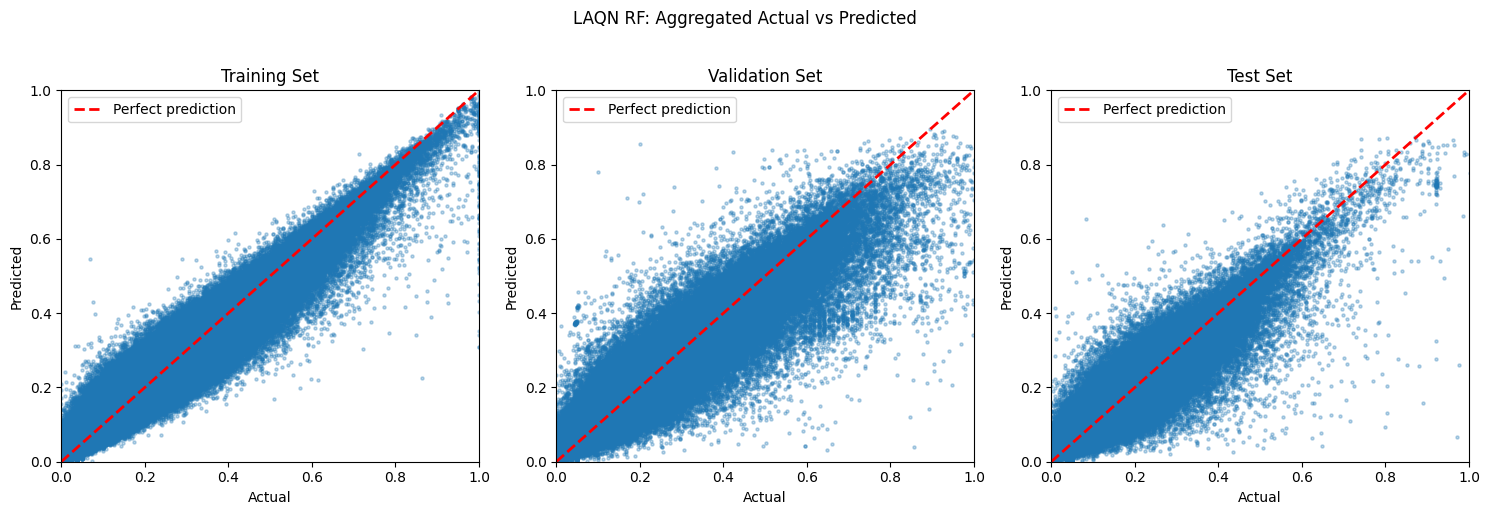

Saved: aggregated_actual_vs_predicted.png

2. Representative plots (one per pollutant)


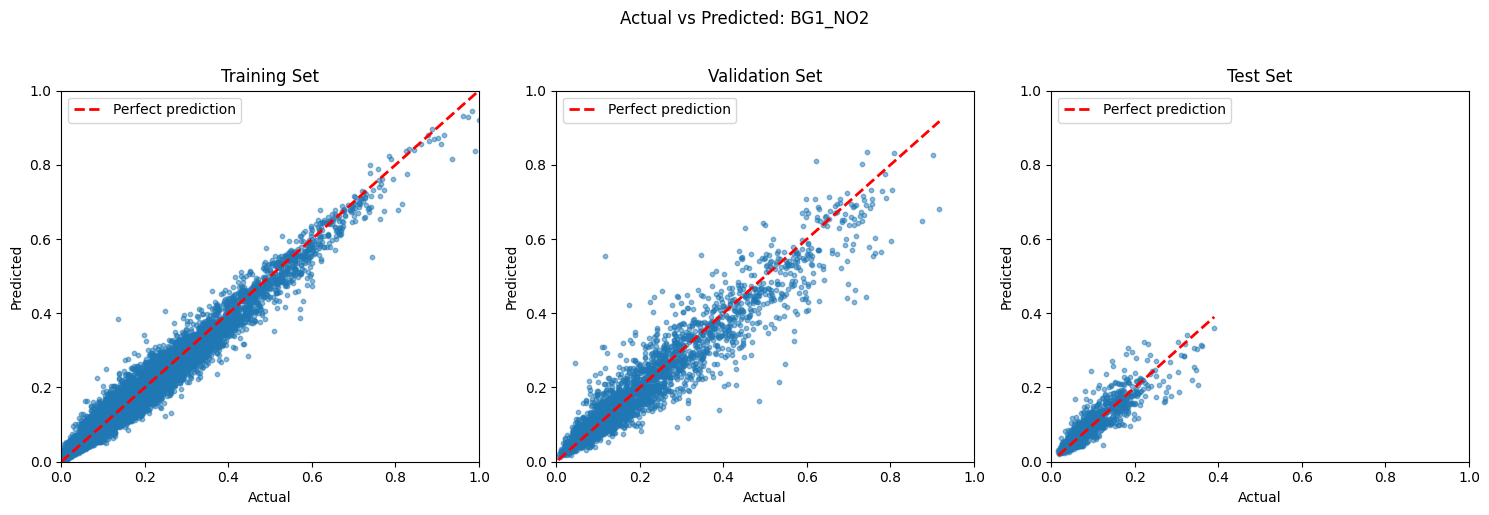

  NO2: BG1_NO2


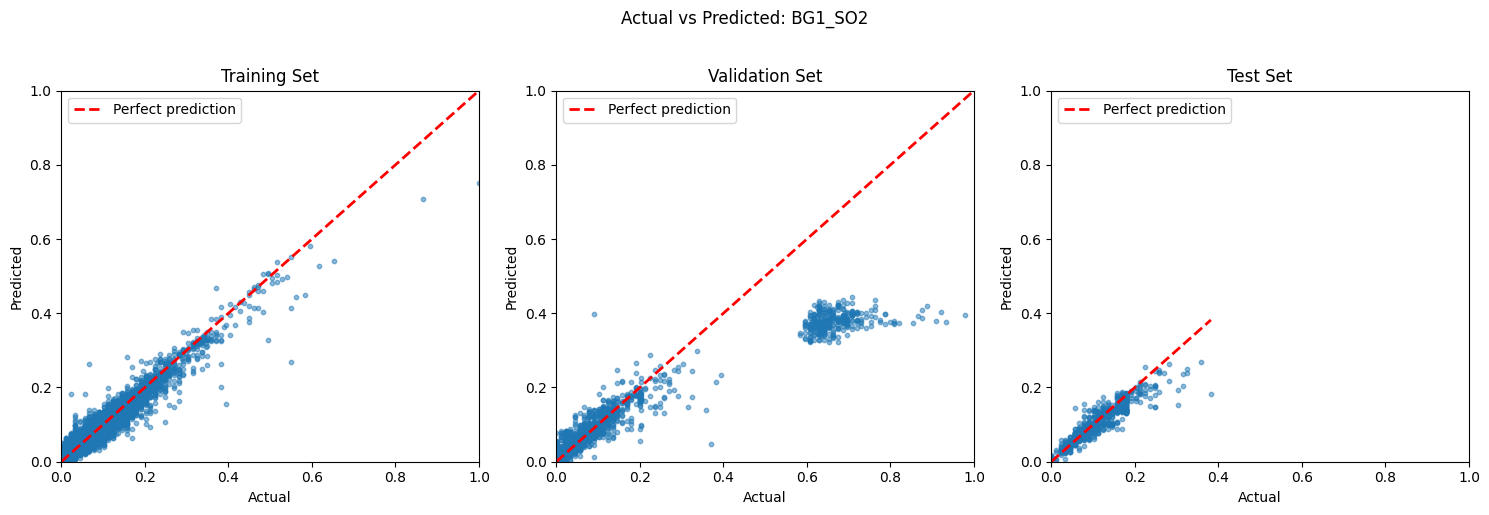

  SO2: BG1_SO2


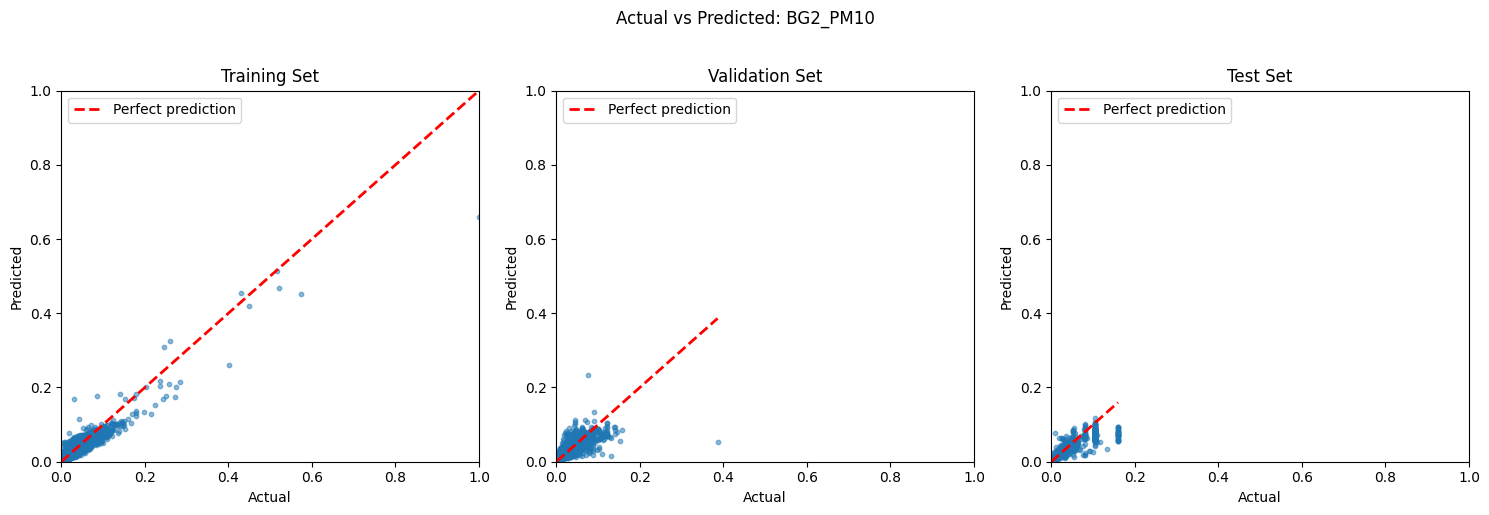

  PM10: BG2_PM10


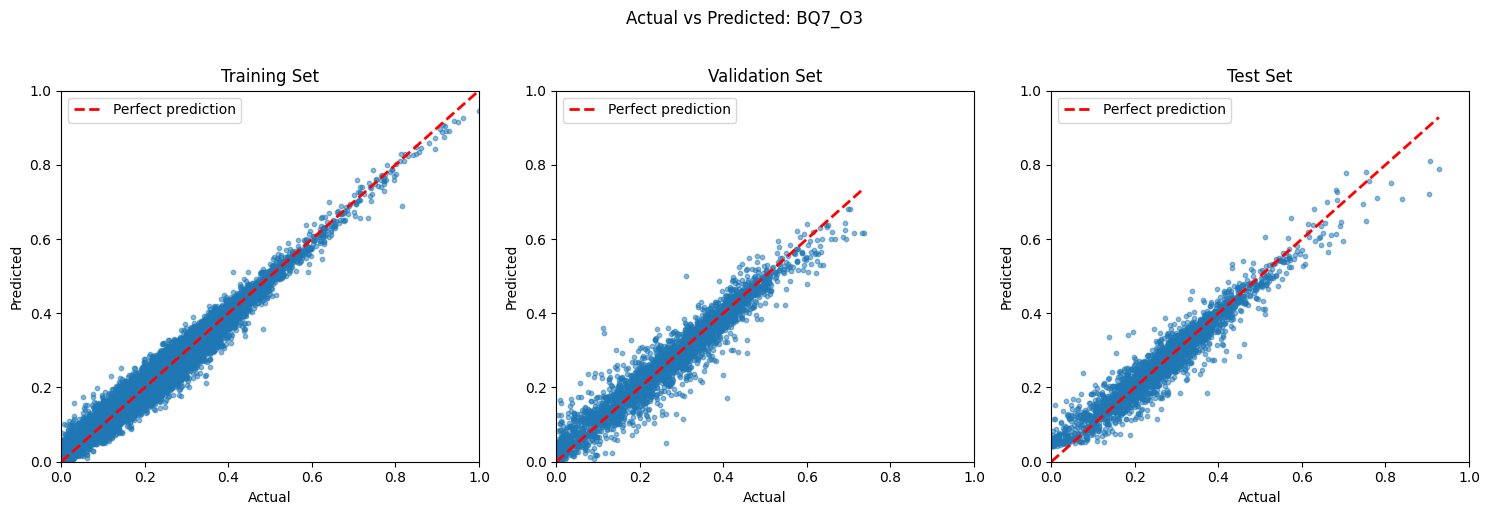

  O3: BQ7_O3


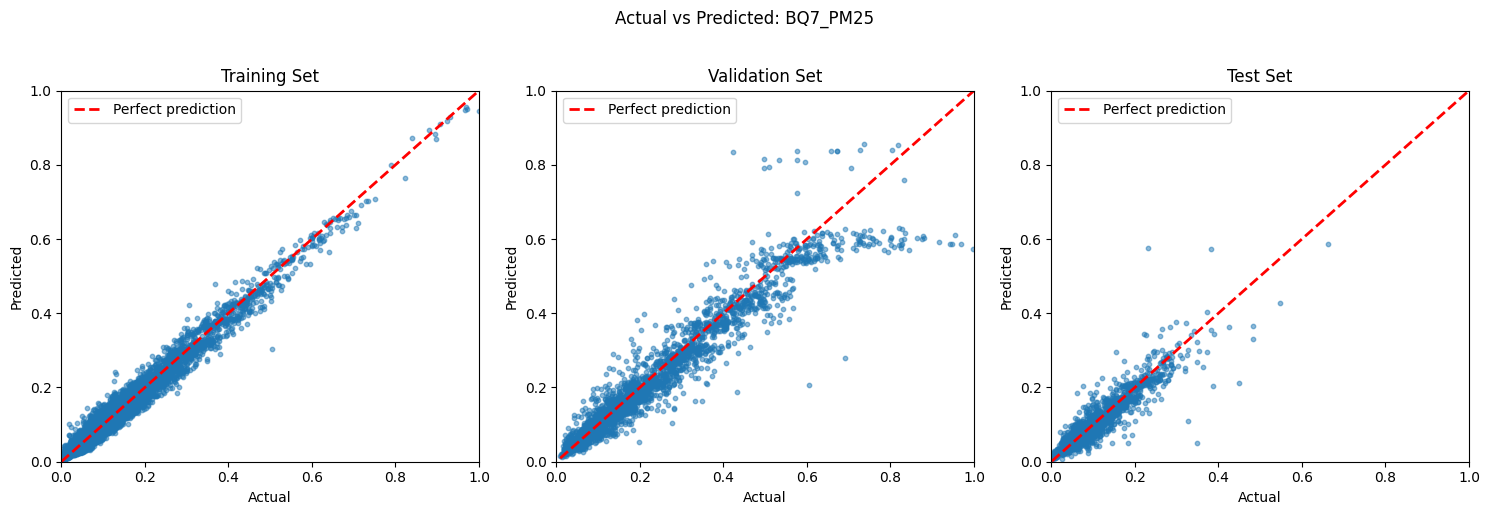

  PM25: BQ7_PM25


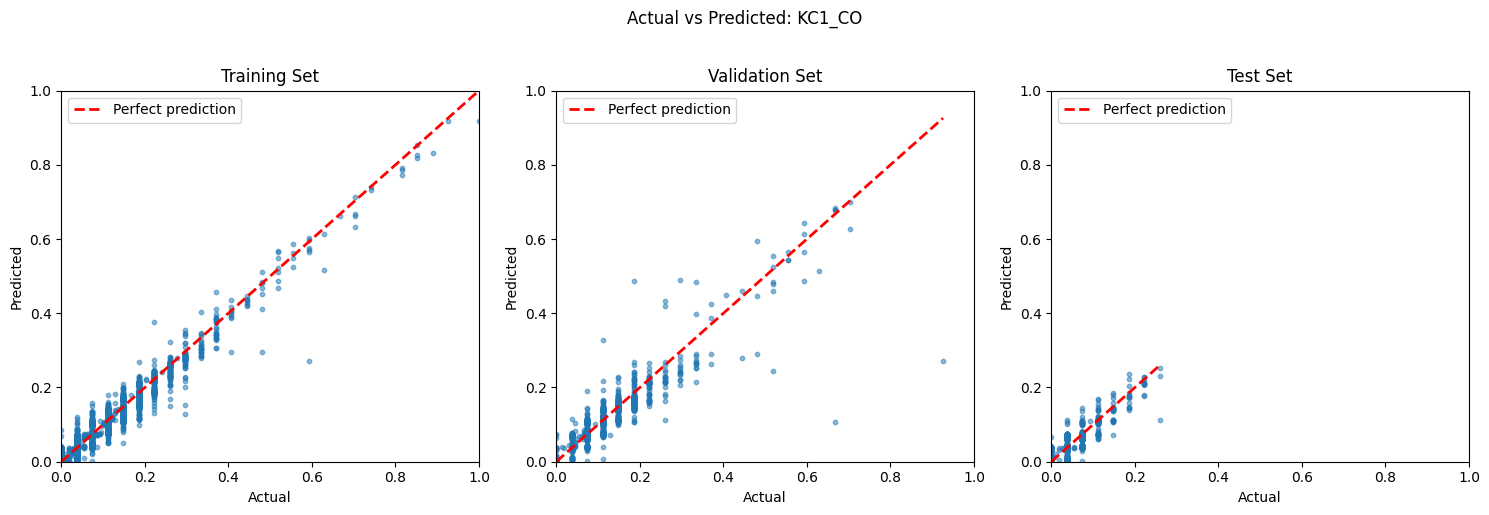

  CO: KC1_CO

3. Best and worst performers


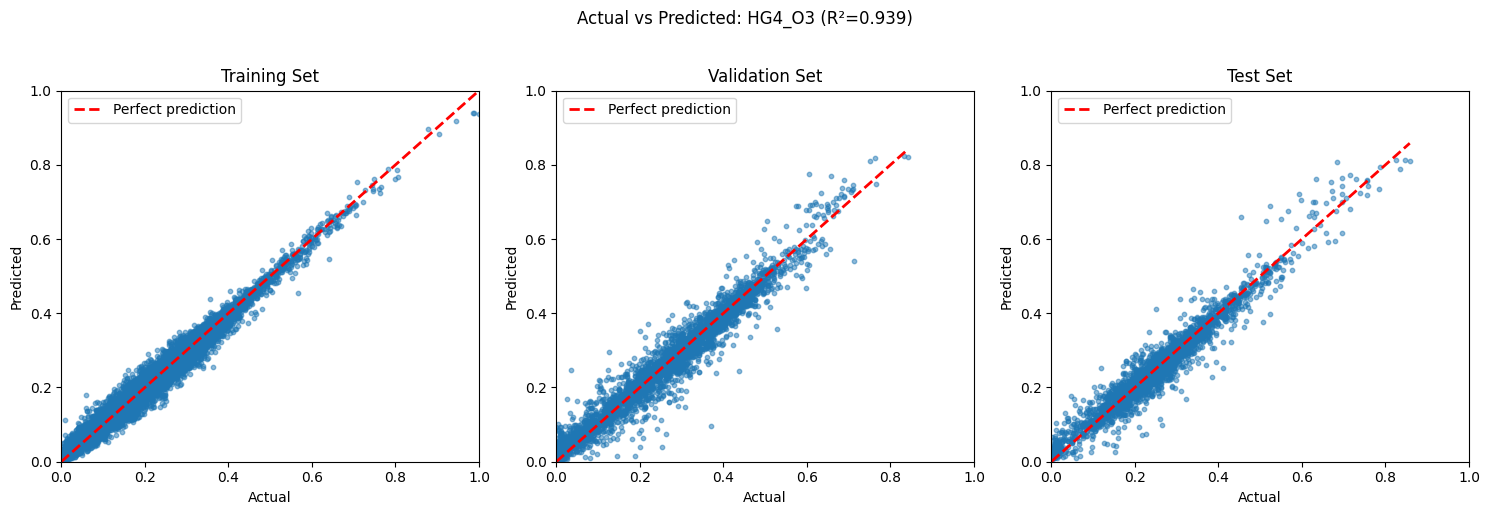

  best: HG4_O3 (R²=0.939)


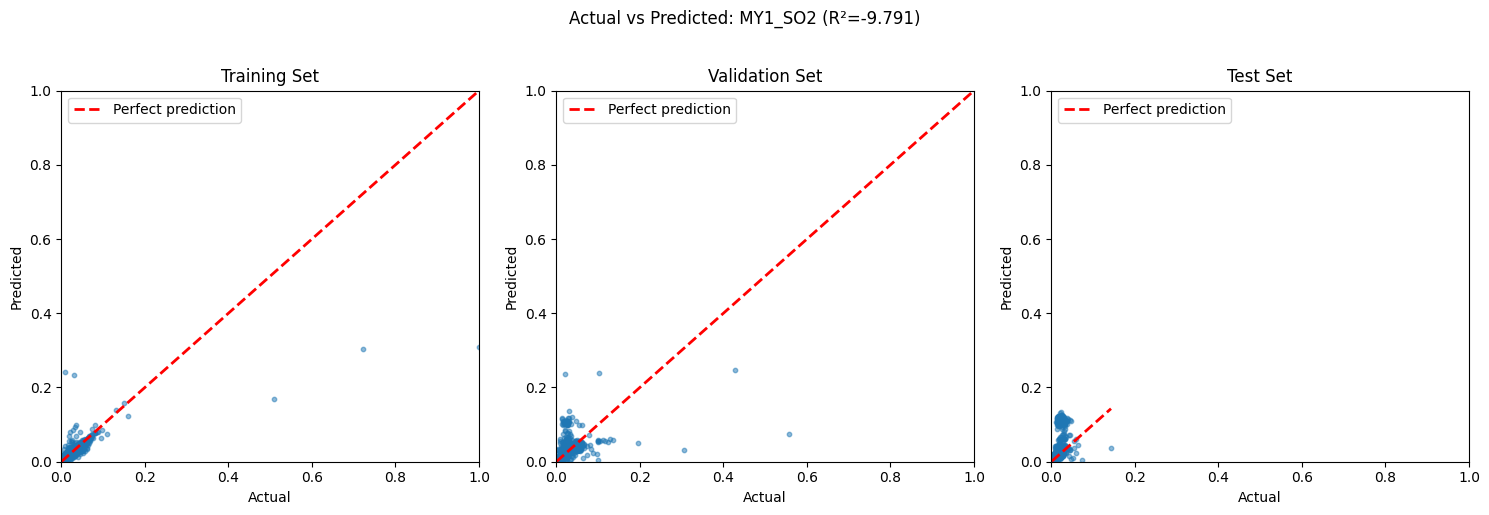

  worst: MY1_SO2 (R²=-9.791)

Done!
Plots saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/dissertation_plots


In [40]:

# Define category function
def get_pollutant_category(name):
    pollutant = name.split('_')[-1]
    if pollutant in ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']:
        return pollutant
    return 'Other'

print("Generating dissertation plots...")

# Create output directory
plots_dir = rf_output_dir / 'dissertation_plots'
plots_dir.mkdir(exist_ok=True)

# Load results to find best/worst
results_df = pd.read_csv(rf_output_dir / 'all_results.csv')
valid_results = results_df[results_df['test_r2'] > -10]

# 1. Aggregated plot
print("\n1. Aggregated plot (all models combined)")

all_train_actual, all_train_pred = [], []
all_val_actual, all_val_pred = [], []
all_test_actual, all_test_pred = [], []

for i, target in enumerate(pollution_targets):
    if target not in all_models:
        continue
    model = all_models[target]
    
    all_train_actual.extend(y_train[:, i])
    all_train_pred.extend(model.predict(X_train_rf))
    all_val_actual.extend(y_val[:, i])
    all_val_pred.extend(model.predict(X_val_rf))
    all_test_actual.extend(y_test[:, i])
    all_test_pred.extend(model.predict(X_test_rf))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
datasets = [
    ('Training Set', all_train_actual, all_train_pred),
    ('Validation Set', all_val_actual, all_val_pred),
    ('Test Set', all_test_actual, all_test_pred)
]

for ax, (title, y_actual, y_pred) in zip(axes, datasets):
    ax.scatter(y_actual, y_pred, alpha=0.3, s=5)
    ax.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect prediction')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(title)
    ax.legend(loc='upper left')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.suptitle('LAQN RF: Aggregated Actual vs Predicted', y=1.02)
plt.tight_layout()
plt.savefig(plots_dir / 'aggregated_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: aggregated_actual_vs_predicted.png")

# 2. One representative per pollutant
print("\n2. Representative plots (one per pollutant)")
plotted_categories = {}

for target in pollution_targets:
    if target not in all_models:
        continue
    
    category = get_pollutant_category(target)
    if category in plotted_categories:
        continue
    
    target_idx = target_mapping[target]
    model = all_models[target]
    
    plot_actual_vs_predicted_3panel(
        model=model,
        X_train=X_train_rf, y_train=y_train[:, target_idx],
        X_val=X_val_rf, y_val=y_val[:, target_idx],
        X_test=X_test_rf, y_test=y_test[:, target_idx],
        target_name=target,
        save_path=plots_dir / f'representative_{category}.png'
    )
    
    plotted_categories[category] = target
    print(f"  {category}: {target}")

# 3. Best and worst performers
print("\n3. Best and worst performers")

best_model = valid_results.loc[valid_results['test_r2'].idxmax(), 'target']
worst_model = valid_results.loc[valid_results['test_r2'].idxmin(), 'target']

for label, target in [('best', best_model), ('worst', worst_model)]:
    target_idx = target_mapping[target]
    model = all_models[target]
    r2 = valid_results[valid_results['target'] == target]['test_r2'].values[0]
    
    plot_actual_vs_predicted_3panel(
        model=model,
        X_train=X_train_rf, y_train=y_train[:, target_idx],
        X_val=X_val_rf, y_val=y_val[:, target_idx],
        X_test=X_test_rf, y_test=y_test[:, target_idx],
        target_name=f"{target} (R²={r2:.3f})",
        save_path=plots_dir / f'{label}_performer.png'
    )
    print(f"  {label}: {target} (R²={r2:.3f})")

print(f"\nDone!")
print(f"Plots saved to: {plots_dir}")